# Activation Foil Analysis: 1L BABY Run #4

This notebook processes the calibration data from NaI detectors to energy calibrate the detectors and determine total detector efficiencies. Then, NaI measurements of activation foils irradiated during the run with a D-T neutron (14.1 MeV) generator are used to determine the average neutron rate during the run. 

## Obtaining the Data
First, the NaI detector measurement data is obtained from Zenodo and extracted

In [1]:
# parameters

## keep this if statement for ci and process workflows
if 'download_from_raw' not in globals() and 'download_from_raw' not in locals():
    download_from_raw = True

In [2]:
import numpy as np
from datetime import datetime
import json

In [3]:
from process_foil_data import get_data
check_source_measurements, background_meas, foil_measurements = get_data(download_from_raw=download_from_raw)


Length of all_json_data: 2
250501_1L_BABY_Run4A
https://zenodo.org/records/15447034/files/250501_1L_BABY_Run4A.zip?download=1
Read in properties of Irradiation 1: Nb Packet #2 foil
Read in properties of Irradiation 1: Zr Packet #1 foil
Directory already exists: ../../data/neutron_detection/activation_foils/irradiation_1
Processing Co60 Count 1...
Processing Co60 Count 2...
Processing Co60 Count 3...
Processing Co60 Count 4...
Processing Co60 Count 5...
Processing Cs137 Count 1...
Processing Cs137 Count 2...
Processing Cs137 Count 3...
Processing Cs137 Count 4...
Processing Cs137 Count 5...
Processing Mn54 Count 1...
Processing Mn54 Count 2...
Processing Mn54 Count 3...
Processing Na22 Count 1...
Processing Na22 Count 2...
Processing Na22 Count 3...
Processing Na22 Count 4...
Processing Na22 Count 5...
Processing background...
Processing Irradiation 1: Nb Packet #2 Count 1...
Processing Irradiation 1: Nb Packet #2 Count 2...
Processing Irradiation 1: Nb Packet #2 Count 3...
Processing I

## Energy Calibration

Using gamma check sources like Co-60 and Cs-137, the characteristic photon peaks from these sources are used to convert the digitizer channel bins into energy (keV) bins

In [6]:
def get_peak_kwargs(nuclide_name, hist):
    if nuclide_name == 'Mn54':
        start_index = 500
        peak_kwargs = {
            'start_index': start_index,
            'prominence': np.max(hist[start_index:]) * 0.5,
            'height': np.max(hist[start_index:]) * 0.5,
        }
    elif nuclide_name == 'Na22':
        start_index = 400
        peak_kwargs = {
            'start_index': start_index,
            'prominence': np.max(hist[start_index:]) * 0.1,
            'height': np.max(hist[start_index:]) * 0.1,
        }
    else:
        peak_kwargs = None
    return peak_kwargs

/tmp/ipykernel_21633/2503920942.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=len(meas.detectors), figsize=(12, 4))


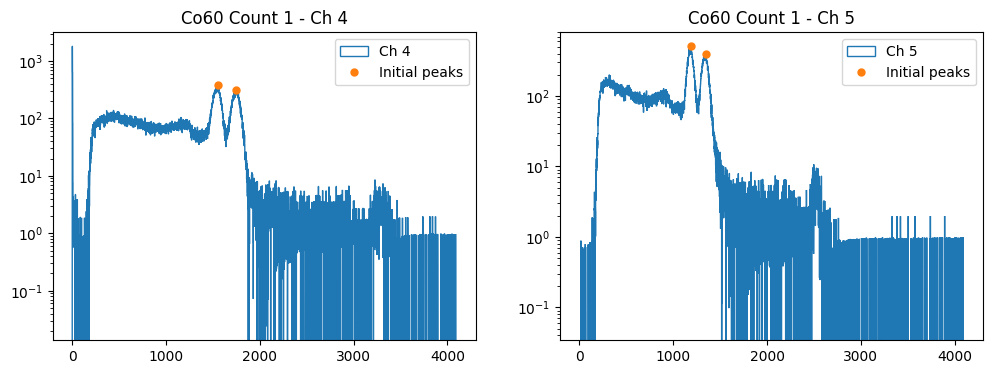

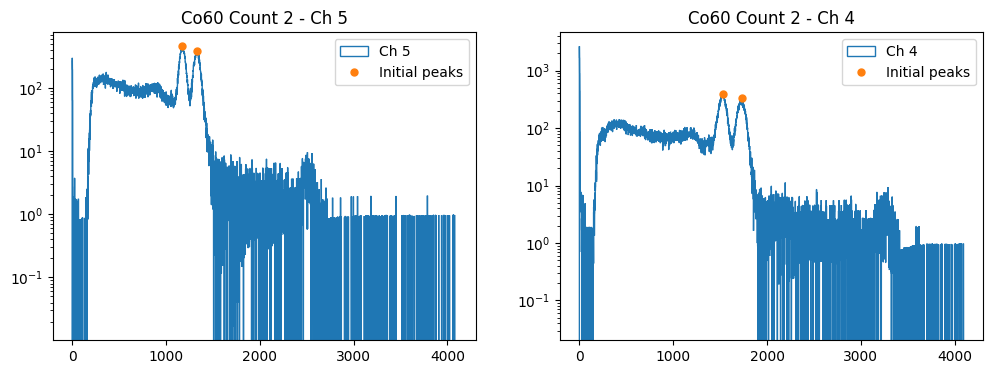

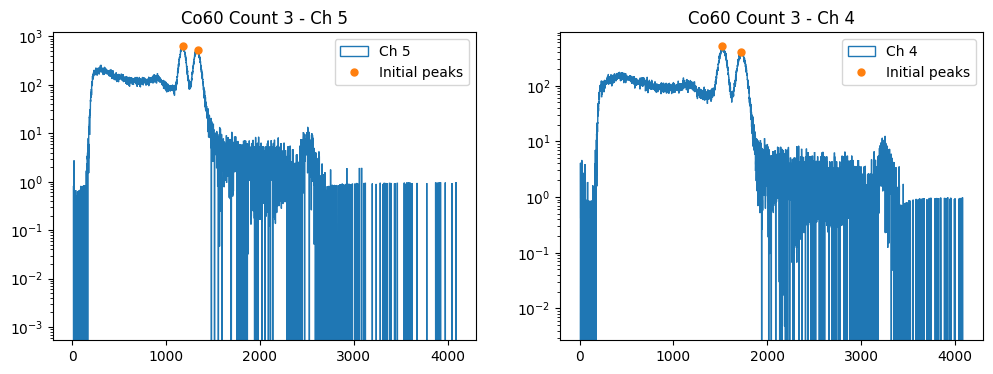

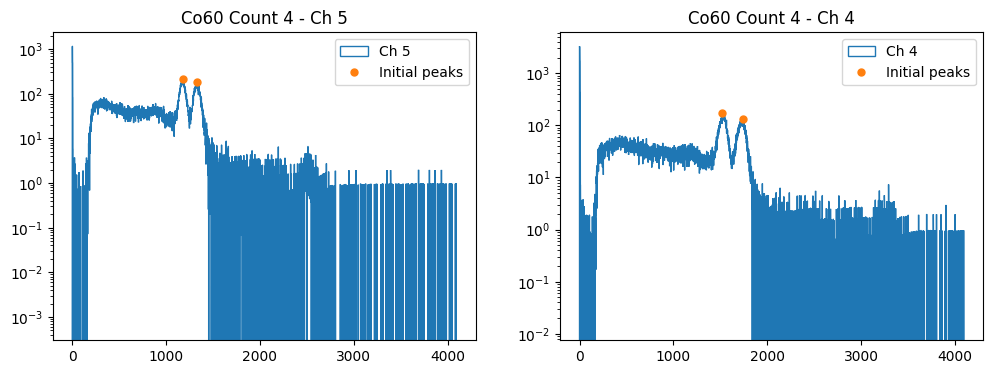

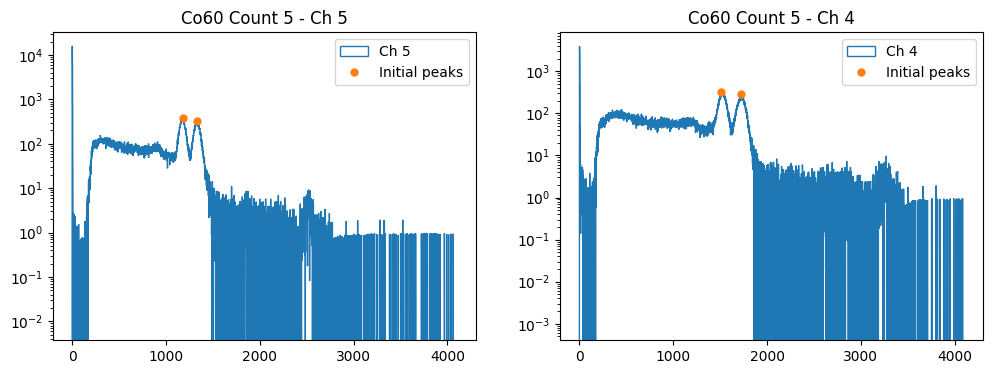

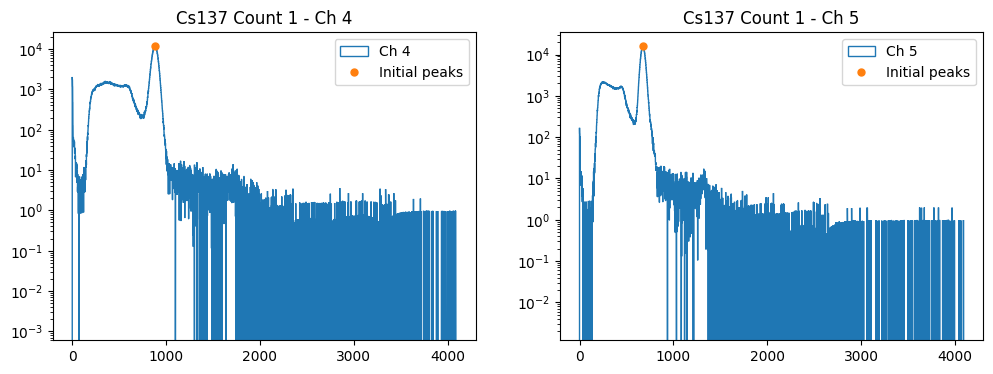

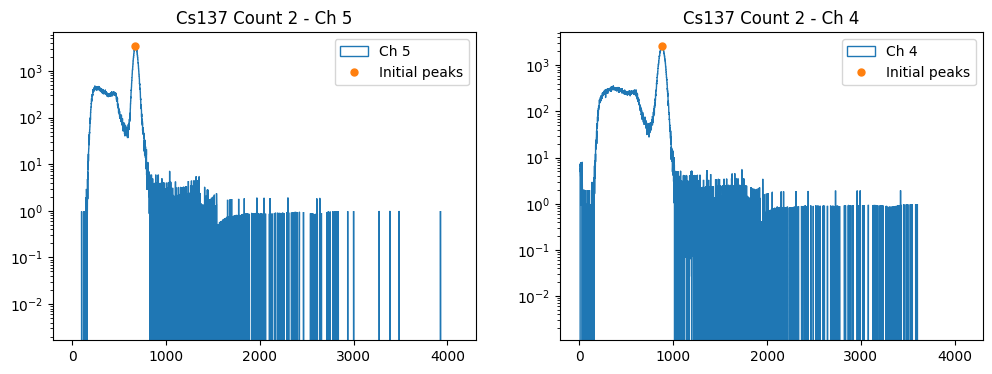

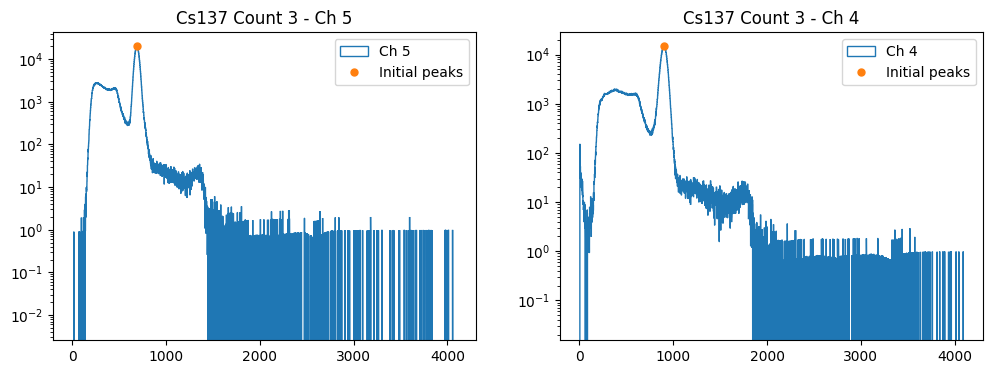

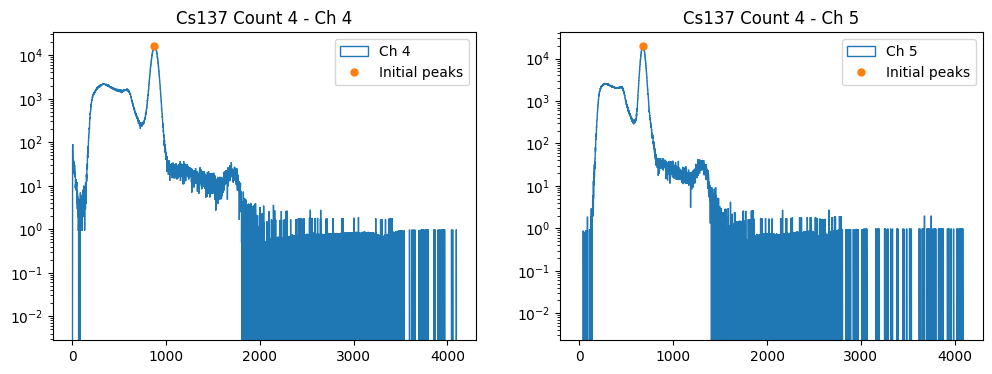

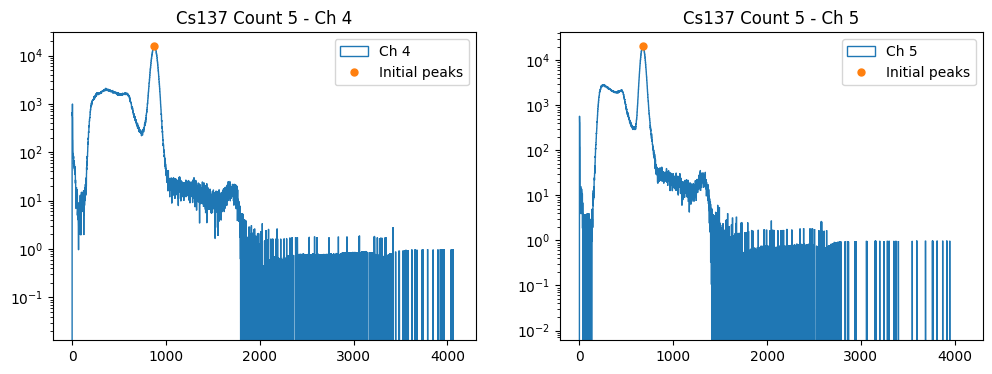

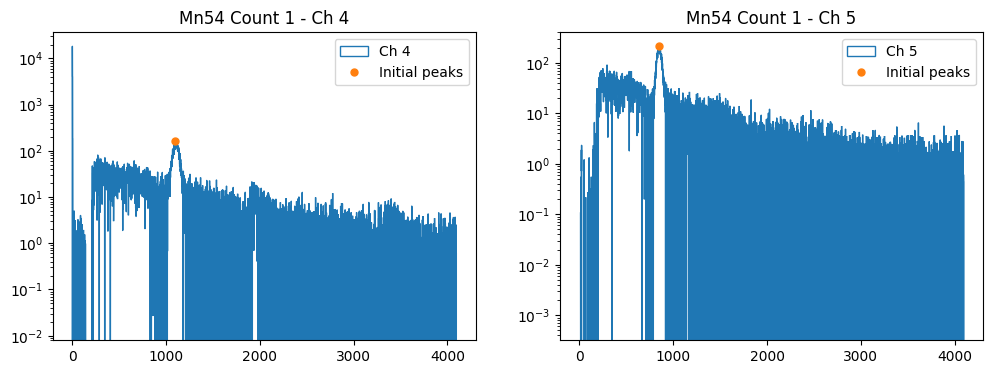

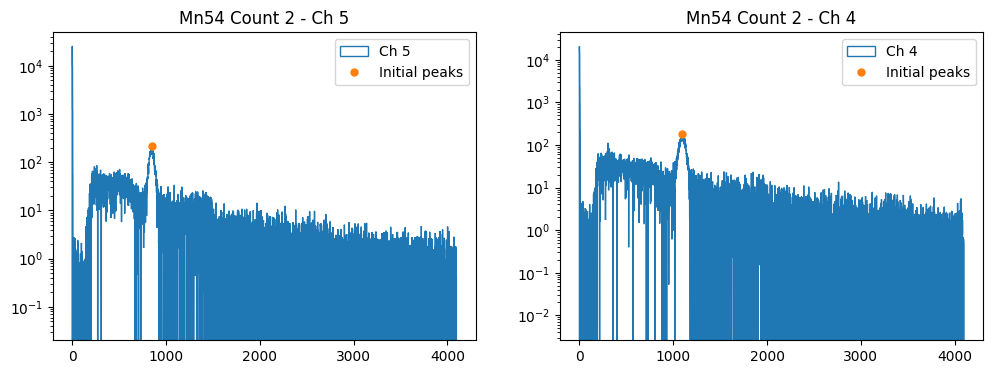

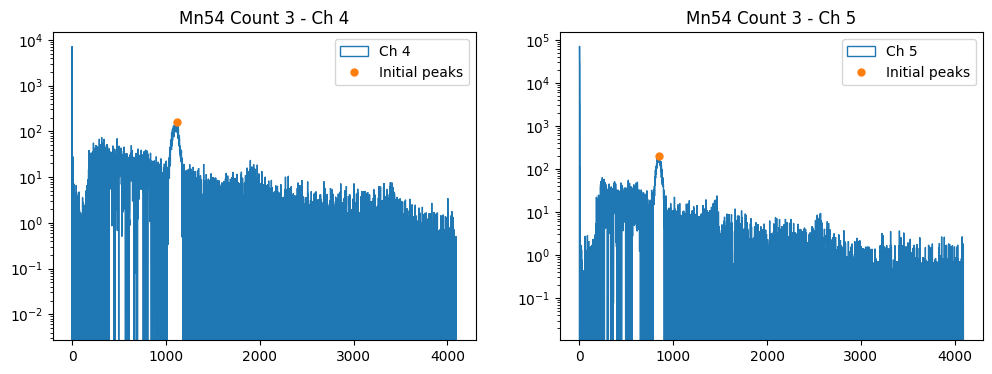

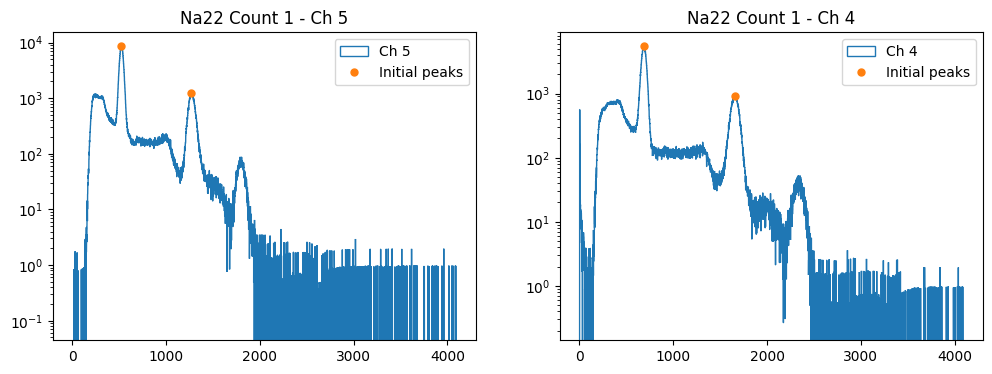

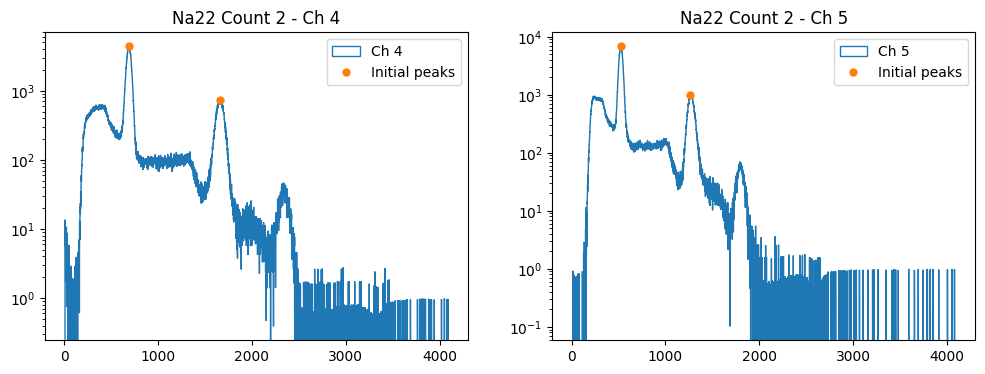

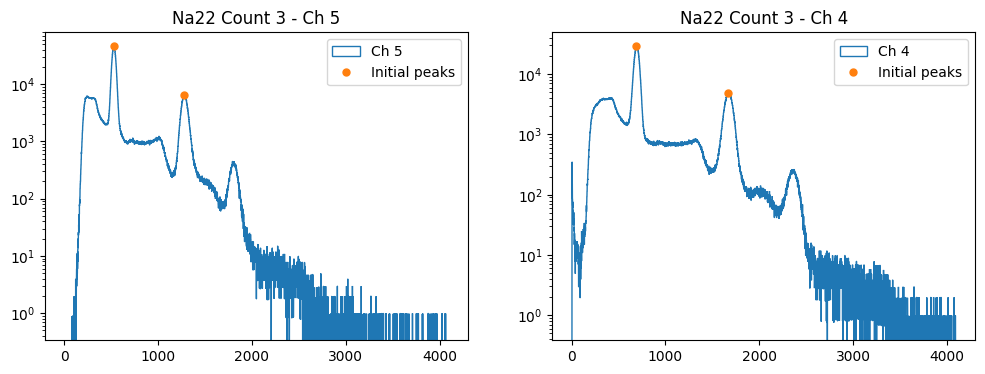

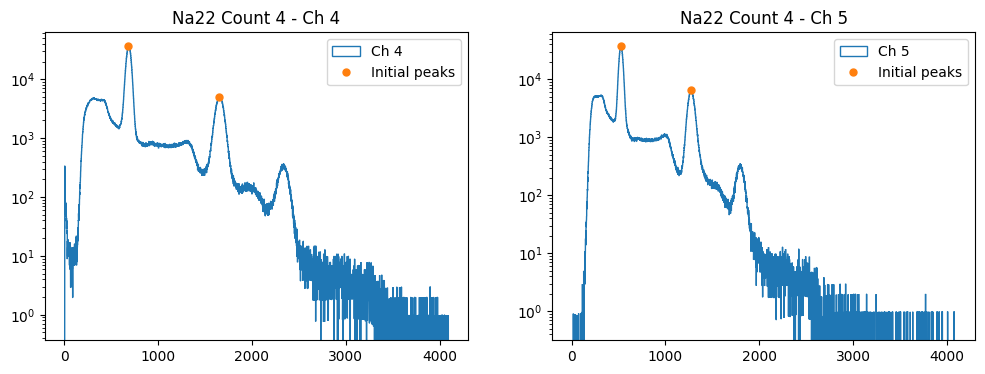

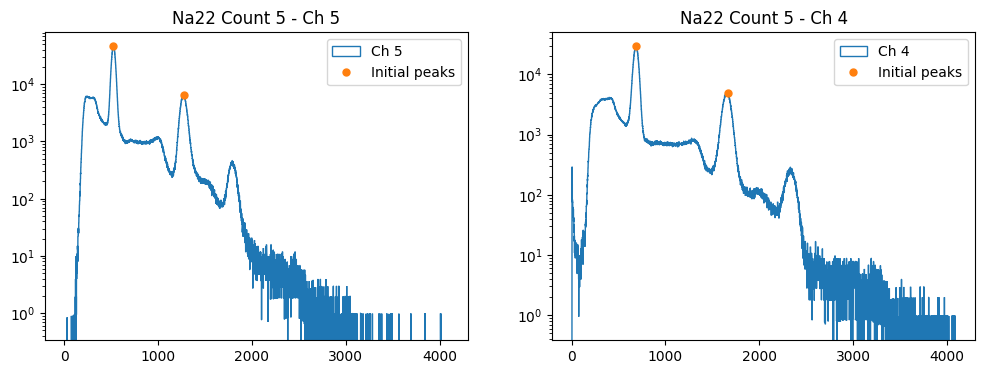

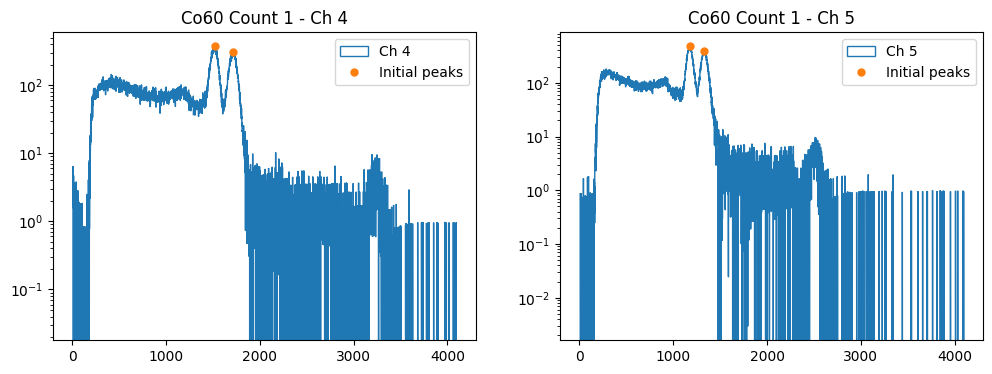

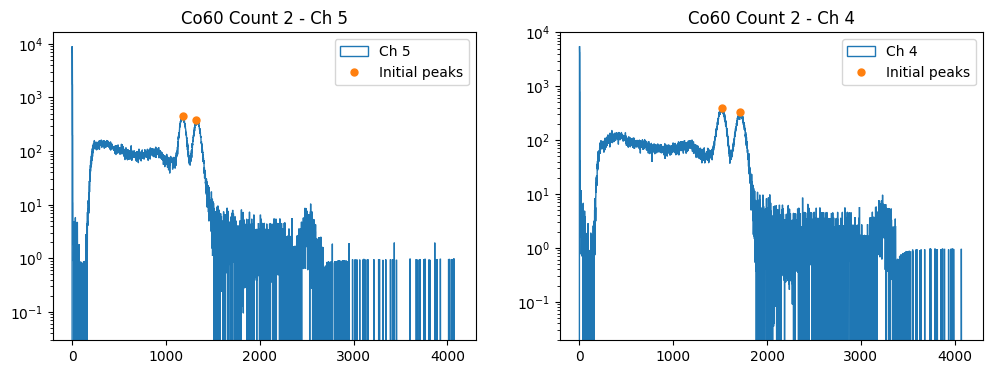

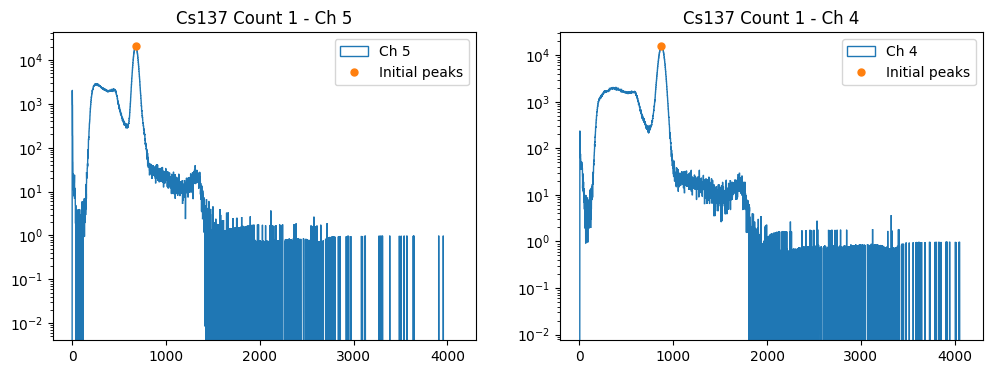

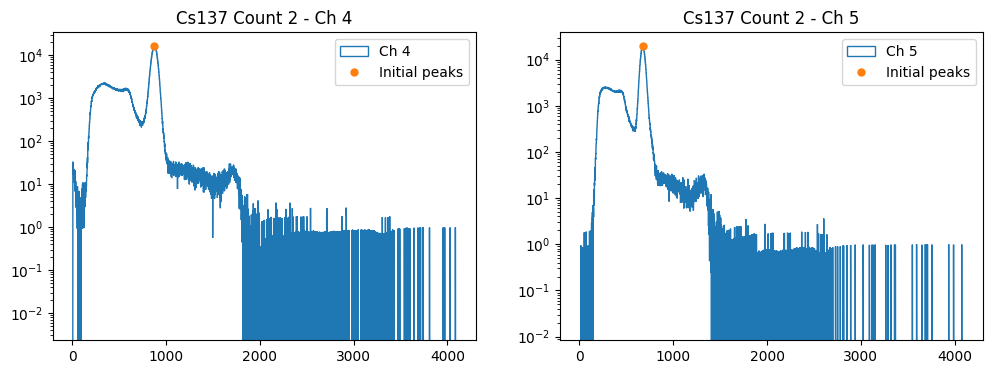

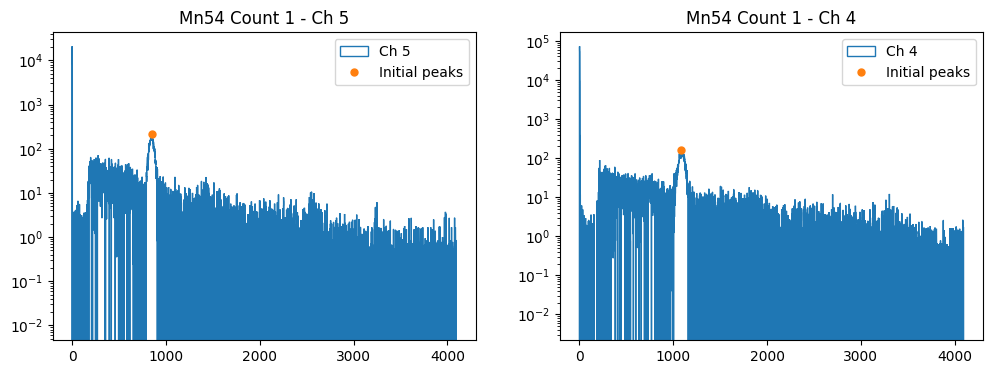

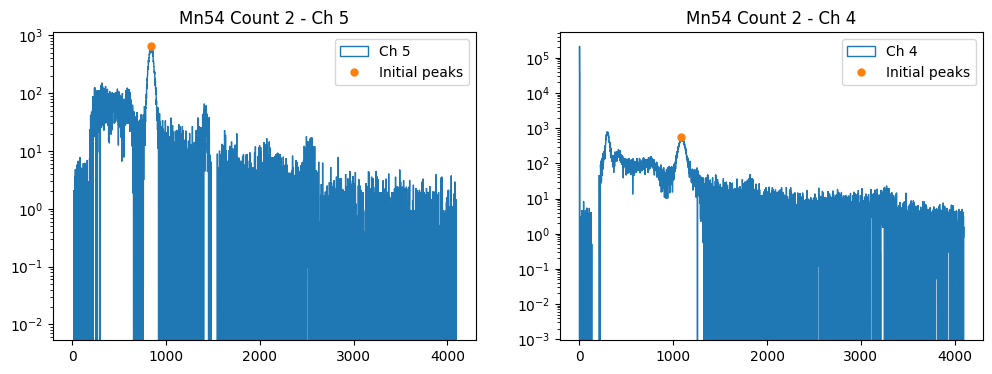

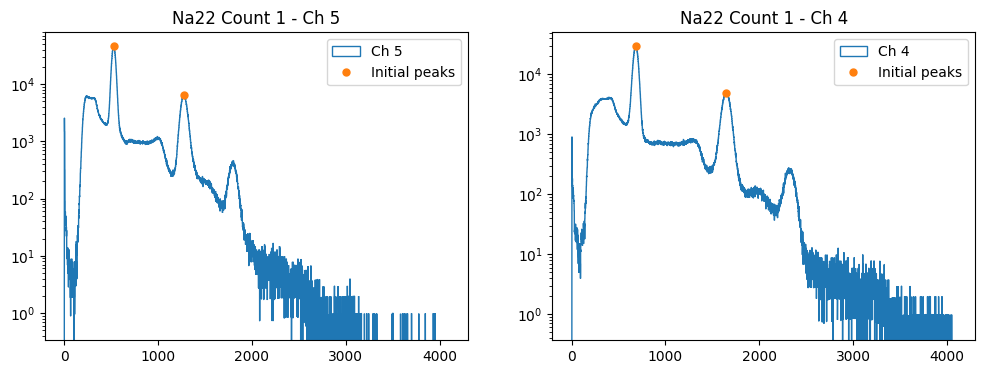

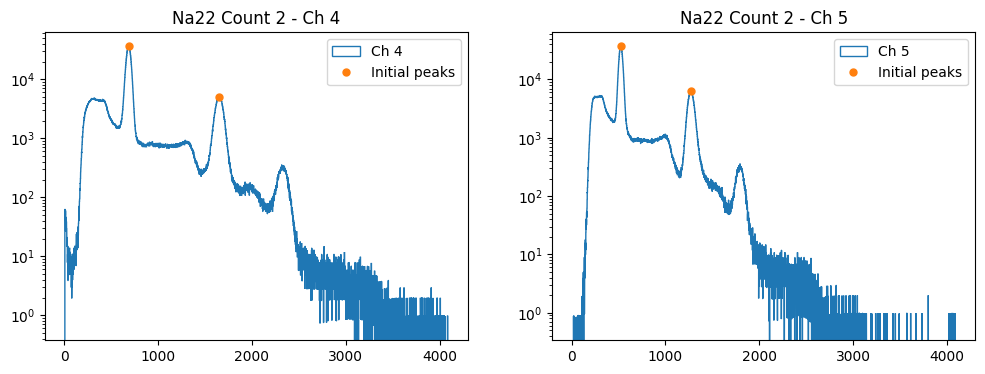

In [12]:
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.activation_foils import compass
from scipy.signal import find_peaks

for i in range(len(check_source_measurements)):
    bg_meas = background_meas[i]
    calibration_channels = {4: [], 5: []}
    calibration_energies = {4: [], 5: []}
    for meas_name, meas in check_source_measurements[i].items():
        fig, ax = plt.subplots(nrows=1, ncols=len(meas.detectors), figsize=(12, 4))
        for d,detector in enumerate(meas.detectors):
            hist, bin_edges = detector.get_energy_hist_background_substract(
                background_detector=bg_meas.get_detector(detector.channel_nb),
            )

            ax[d].hist(
                bin_edges[:-1],
                bins=bin_edges,
                weights=hist,
                histtype="step",
                label=f"Ch {detector.channel_nb}",
            )
            peak_kwargs = get_peak_kwargs(meas.check_source.nuclide.name, 
                                        hist)
            if peak_kwargs:
                peaks_ind = meas.get_peaks(hist, **peak_kwargs)
            else:
                peaks_ind = meas.get_peaks(hist)

            ax[d].plot(bin_edges[peaks_ind], hist[peaks_ind], "o", ms=5, label="Initial peaks")

            peaks = bin_edges[peaks_ind]

            if len(peaks) != len(meas.check_source.nuclide.energy):
                raise ValueError(
                    f"SciPy find_peaks() found {len(peaks)} photon peaks, while {len(meas.check_source.nuclide.energy)} were expected"
                )
            calibration_channels[detector.channel_nb] += list(peaks)
            calibration_energies[detector.channel_nb] += meas.check_source.nuclide.energy

            ax[d].legend()
            ax[d].set_yscale("log")
            # ax[d].set_ylim(top=2100)
            ax[d].set_title(f"{meas_name} - Ch {detector.channel_nb}")
plt.show()

In [ ]:
calibration_coeffs = []
for i in range(len(check_source_measurements)):
    calibration_coeffs_dict = {}
    for ch in calibration_channels.keys():
        sort_inds = np.argsort(calibration_channels[ch])
        calibration_channels[ch] = np.array(calibration_channels[ch])[sort_inds]
        calibration_energies[ch] = np.array(calibration_energies[ch])[sort_inds]
        coeffs = np.polyfit(calibration_channels[ch], calibration_energies[ch], deg=1)
        calibration_coeffs_dict[ch] = coeffs
    calibration_coeffs.append(calibration_coeffs_dict)
    calibration_coeffs_dict = {}
    check_source_meas = check_source_measurements[i]
    bg_meas = background_meas[i]
    for channel_nb in [4, 5]:
        calibration_channels, calibration_energies = compass.get_calibration_data(
            check_source_meas,
            background_measurement=bg_meas,
            channel_nb=channel_nb,
        )
        coeffs = np.polyfit(calibration_channels, calibration_energies, deg=1)
        calibration_coeffs_dict[channel_nb] = coeffs
        print(f"Calibration coefficients for channel {channel_nb}: {coeffs}")
        # Plot the calibration curve
        plt.figure()
        plt.scatter(calibration_channels, calibration_energies, label="Data points")
        plt.plot(
            calibration_channels,
            np.polyval(coeffs, calibration_channels),
            color="red",
            label="Fitted line",
        )
        plt.xlabel("Channel Number")
        plt.ylabel("Energy (keV)")
        plt.title(f"Energy Calibration for Channel {channel_nb}")
        plt.legend()
        plt.grid()
        plt.show()
    calibration_coeffs.append(calibration_coeffs_dict)

{'Co60 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f726397ee40>, 'Co60 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f724cb2d010>, 'Co60 Count 3': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f724afb7620>, 'Co60 Count 4': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f724b98df70>, 'Co60 Count 5': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f724aa2a4b0>, 'Cs137 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f724abc37d0>, 'Cs137 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f724aa2b200>, 'Cs137 Count 3': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f724aa28170>, 'Cs1

ValueError: SciPy find_peaks() found 3 photon peaks, while 2 were expected

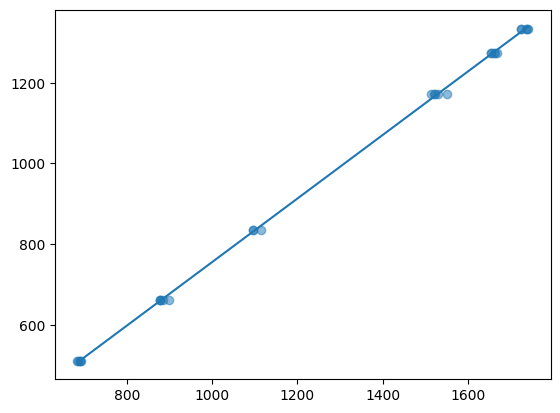

In [5]:

calibration_coeffs = []

for i in range(len(check_source_measurements)):
    calibration_coeffs_dict = {}
    check_source_meas = check_source_measurements[i]
    bg_meas = background_meas[i]

    print(check_source_meas)

    for channel_nb in [4, 5]:
        calibration_channels, calibration_energies = compass.get_calibration_data(
            check_source_meas.values(),
            background_measurement=bg_meas,
            channel_nb=channel_nb,
        )

        coeff = np.polyfit(calibration_channels, calibration_energies, 1)
        calibration_coeffs_dict[channel_nb] = coeff

        xs = np.linspace(
            calibration_channels[0],
            calibration_channels[-1],
        )
        plt.plot(
            xs,
            np.polyval(coeff, xs),
            label=f"Ch {channel_nb} fit",
        )
        plt.scatter(
            calibration_channels,
            calibration_energies,
            label=f"Ch {channel_nb} data",
            alpha=0.5,
        )
    plt.xlabel("Channel number")
    plt.ylabel("Energy (keV)")
    plt.legend()
plt.show()

## Detector Efficiency

Using these same check-sources, each with a known activity, an efficiency curve for each detector is calculated. 

Two types of efficiency curves are shown: 
1. Exponent of sum of logarithms (used in https://doi.org/10.2172/1524045): $ y = \exp(\sum_{i=0}^n a_n \log(E)^i) $

2. Polynomial fit (3rd order): $ y = \sum_{i=0}^n a_n E^i $

**Only the polynomal fit is currently implemented in libra-toolbox, so that is the curve that will be used to calculate the efficiency of the detectors at measuring the activity of the activation foil peaks.**

In [ ]:
def eff_curve_func(E, *a):
    exponent_term = 0
    for i,a_n in enumerate(a):
        exponent_term += a_n * (np.log(E) ** i)
    return np.exp(exponent_term)

In [ ]:
from scipy.optimize import curve_fit

channels = []
efficiency_coeffs = {}
measurement = list(check_source_measurements.values())[0]
search_width = 330

for detector in measurement.detectors:
    channels.append(detector.channel_nb)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i,ch in enumerate(channels):
    background_detector = background_meas.get_detector(ch)
    energies = []
    efficiencies = []
    for name, measurement in check_source_measurements.items():
        check_source_detector = measurement.get_detector(ch)
        hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector)
        calibrated_bin_edges = np.polyval(calibration_coeffs[ch], bin_edges)
        
        efficiency = measurement.compute_detection_efficiency(
            background_measurement=background_meas,
            calibration_coeffs=calibration_coeffs[ch],
            channel_nb=ch,
            search_width=search_width,
        )
        energies += measurement.check_source.nuclide.energy
        efficiencies += list(efficiency)
        ax[i].scatter(
            measurement.check_source.nuclide.energy,
            efficiency * 100,
            label=name,
        )

    # Sort energies and efficiencies for fitting
    sorted_indices = np.argsort(energies)
    energies = np.array(energies)[sorted_indices]
    efficiencies = np.array(efficiencies)[sorted_indices]
    print(f"Ch {ch} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

    # Fit the efficiency curve
    popt, pcov = curve_fit(
        eff_curve_func,
        energies,
        efficiencies,
        p0=[-1, 1, 0, 0],
    )

    poly_coeff = np.polyfit(energies, efficiencies, 3)
    efficiency_coeffs[ch] = poly_coeff
    xs = np.linspace(
        energies[0],
        energies[-1],
        100,
    )
    ax[i].plot(
        xs,
        eff_curve_func(xs, *popt) * 100,
        label="Fitted efficiency curve",
    )

    ax[i].plot(
        xs,
        np.polyval(poly_coeff, xs) * 100,
        label="Polyfit efficiency curve",
    )
    ax[i].set_xlabel("Energy (keV)")
    ax[i].set_ylabel("Detection efficiency (%)")
    ax[i].set_title(f"Channel {ch}")
    ax[i].legend()
    # plt.ylim(bottom=0)
    print(popt)
plt.show()

## Calculating average neutron rate from activation foils

First, the irradiation schedule and the foil information is collected.

In [ ]:
all_neutron_rates = []
all_neutron_rates_err = []

In [ ]:
from process_foil_data import irradiations, time_generator_off

### Niobium Packet #3 Results

The activity of Nb-92m is measured using its 934 keV gamma peak and used to determine the neutron rate during the irradiation. Nb-92m is formed from the Nb-93(n,2n) reaction, which has a threshold energy of 8.9 MeV. 

The gamma spectrum obtained from the various measurements of the Niobium Packet #3 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [ ]:
from process_foil_data import calculate_neutron_rate_from_foil

foil_name = "Nb Packet #3"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=search_width)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])


### Zirconium Packet #1 Results

The activity of Zr-89 is measured using its 909 keV gamma peak and used to determine the neutron rate during the irradiation. Zr-89 m is formed from the Zr-90(n,2n) reaction, which has a threshold energy of 12.1 MeV. 

The gamma spectrum obtained from the various measurements of the Zirconium Packet #1 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [ ]:
foil_name = "Zr Packet #1"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=search_width)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])

### Averaging foil results

The average of the neutron rates of the Niobium and Zirconium foil packets is calculated and added to the processed_data.json file. 

In [ ]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

In [ ]:
processed_data_file = "../../data/processed_data.json"

processed_data = {
    "neutron_rate_used_in_model": {
        "value":average_neutron_rate,
        "error": average_neutron_rate_err,
        "unit": "neutron / second"
    }
}

try:
    with open(processed_data_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    print(f"Processed data file not found, creating it in {processed_data_file}")
    existing_data = {}

existing_data.update(processed_data)

with open(processed_data_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Processed data stored in {processed_data_file}")